Predictor Training
==============

This notebook trains a model that learns the original, non-differentiable Jones et al. model and evaluates how well the learned model outputs compare to the Jones et al. model outputs.
https://www.nature.com/articles/s41587-020-0646-5

Essentially, this notebooks starts off very similar to `01_train_predictor`, then compares the model output of 50,000 oligo pairs to the output of the Jones et al. model on those same 50,000 pairs.  

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import primo.models
import primo.tools.sequences as seqtools
import primo.models.cas9 as cas9


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dnqiba8i because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Reserve space on the GPU for running simulations. It's important to do this before running any tensorflow code (which will take all available GPU memory):

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
simulator = primo.models.Simulator()

# Useful functions to use throughout this notebook

In [4]:
def get_keras_pairs(seq_pairs):
    """
    Given the data frame seq_pairs,
    returns a tensor flow object with all of the sequence pairs in appropriate tensor format
    """
    # get the validation sequence pairs
    only_seq_pairs = seq_pairs[['target_features', 'query_features']]

    # Convert to onehots
    target_onehots = seqtools.seqs_to_onehots(only_seq_pairs.target_features)
    query_onehots = seqtools.seqs_to_onehots(only_seq_pairs.query_features)

    # Convert to a tensor for input to keras function (or predictor model)
    pairs = tf.convert_to_tensor(
        np.transpose(np.stack([target_onehots, query_onehots]), [1, 0, 2, 3]),
        dtype=tf.float32
    )
    return pairs

## Generate a large set of pairs with various Hamming distances

Comment out once the large set has been generated so that we keep the same validation set

In [4]:
# # Generate two random DNA sequences. First by creating a random sequence, then copying that sequence to another sequence, then mutating that second sequence at some given mutation rate, such that 
# # the hamming distance between the sequences (i.e. how different they are) is sampled from a uniform distribution. This means that we could expect sequence that are nearly identical, and sequence pairs that are entirely opposite to occur at approximately the same rate. 
# # Random_pairs: (arbitrary_sequence_1, arbitrary_sequence_2)

# # Generate 50,000 of these arbitrary sequence pairs.
# n_sequence_pairs_to_generate = 50000

# sequence_length = 20

# random_pairs, mut_rates = seqtools.random_mutant_pairs(n_sequence_pairs_to_generate, sequence_length)

In [5]:
# # From here, we take the first arbitrary sequence, and its mutation (i.e. the random pairs), 
# # then we pretend that the first arbitrary sequence (i.e. at index 0) is a target DNA sequence, 
# # then we pretend the second arbitrary sequence (i.e. at index 1) is a query DNA sequences. 
# seq_pairs = pd.DataFrame({
#     "target_features": random_pairs[:, 0],
#     "query_features": random_pairs[:, 1]
# })

In [6]:
# write to csv
# seq_pairs.to_csv('seq_pairs.csv')

# read from csv
seq_pairs = pd.read_csv('seq_pairs_jones.csv')
# seq_pairs = seq_pairs.iloc[:,1:]

In [7]:
seq_pairs

,Unnamed: 0,target_features,query_features,crispr_score_jones
0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200
1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335
2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200
3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200
4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200
...,...,...,...,...
49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000
49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338
49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200
49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200


## Simulate the query-target yields from primo.models.simulator 
These should be the same values as the Jones et al. model, but let's confirm

In [58]:
# # do simulation
# only_seq_pairs = seq_pairs[['target_features', 'query_features']]
# sim_results = simulator.simulate(only_seq_pairs)

# # add fourth column to seq_pairs table, 'primo_simulator'
# indexes = np.array([i for i in range(len(sim_results))])
# sim_results_df = pd.DataFrame({'primo_simulator': sim_results, 'Unnamed: 0': indexes})
# seq_pairs = seq_pairs.merge(sim_results_df, on='Unnamed: 0')
# print(seq_pairs)

# # write to csv
# seq_pairs.to_csv('seq_pairs_jones_primosim.csv')

# # check if 'crispr_score_jones' and 'primo_simulator' columns are equal
# is_equal = seq_pairs['crispr_score_jones'].equals(seq_pairs['primo_simulator'])
# print(is_equal)

seq_pairs = pd.read_csv('seq_pairs_jones_primosim.csv')
seq_pairs = seq_pairs.iloc[:,1:]
print(seq_pairs)

       Unnamed: 0.1       target_features        query_features  \
0                 0  CGCGGGTGGGTTCTACGTCT  TCCGAGAGCGATGTCCACTT   
1                 1  GGAGGGTCAACCGACATATG  GGAGGGTCAACTGACATATG   
2                 2  ATCAAGTTACGCACCGAGGA  TTCAAGTTACGCACCTAGCC   
3                 3  CCATGTTAAAGCAAAGGATT  CCAGTTTATTGAGCCGATTT   
4                 4  ACGCCGGGTTCAGTATCCTC  GGGCGATGTACAGCAAAATA   
...             ...                   ...                   ...   
49995         49995  CTTGAGGTCATCACTCACAA  CTTGAGGTCATCACTCACAA   
49996         49996  CCCAGGATTACTGGCCCGCT  CCCAGGATTAGTGGCCGGCT   
49997         49997  TACTCCCATTTGTATGGGAT  ATTATGTCCGGTATGCCTTG   
49998         49998  GCGTAGTTTGCGAGTGAGGT  GCGTGGTTCGCGAGTGATAT   
49999         49999  AGCACTAGATTAGGTAATCA  GAAATGCTATCGAGGCAACA   

       crispr_score_jones  primo_simulator  
0                0.000200         0.000200  
1                0.070335         0.070335  
2                0.000200         0.000200  
3              

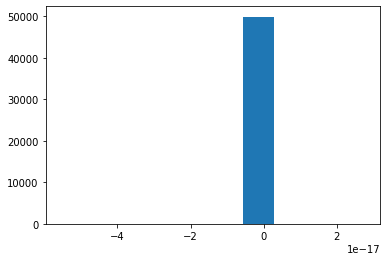

In [59]:
# figure out where the differences are between 'crispr_score_jones' and 'primo_simulator'
# a quick spot check of the .csv file yields no insight

a = seq_pairs['crispr_score_jones'] - seq_pairs['primo_simulator']

plt.hist(a)
plt.show()

Conclusion: We have correctly implemented our simulator. Differences between the original Jones et al. model and our model are likely due to floating point errors (all differences are ~1e-17 large)

## Train an ML model to learn the simulator

Then run the model on our 50,000 pairs and add that simulated crispr score to our seq_pairs dataframe so we can get a good understanding of how it compares to the original model.

Generate a large set of pairs with various Hamming distances and get their 'yield values' AKA crispr scores from the primo model

In [8]:
# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [137]:
# Generate two random DNA sequences. First by creating a random sequence, then copying that sequence to another sequence, then mutating that second sequence at some given mutation rate, such that 
# the hamming distance between the sequences (i.e. how different they are) is sampled from a uniform distribution. This means that we could expect sequence that are nearly identical, and sequence pairs that are entirely opposite to occur at approximately the same rate. 
# Random_pairs: (arbitrary_sequence_1, arbitrary_sequence_2)

# Generate n arbitrary sequence pairs.
n_sequence_pairs_to_generate = 500000

sequence_length = 20

random_pairs, mut_rates = seqtools.random_mutant_pairs(n_sequence_pairs_to_generate, sequence_length)

# From here, we take the first arbitrary sequence, and its mutation (i.e. the random pairs), 
# then we pretend that the first arbitrary sequence (i.e. at index 0) is a target DNA sequence, 
# then we pretend the second arbitrary sequence (i.e. at index 1) is a query DNA sequences. 
only_seq_pairs = pd.DataFrame({
    "target_features": random_pairs[:, 0],
    "query_features": random_pairs[:, 1]
})

sim_results = simulator.simulate(only_seq_pairs)


Initialize a random predictor and train it on the sequences and simulated yields:

In [138]:
predictor = primo.models.PredictorModel()

In [139]:
onehot_seq_pairs = predictor.seq_pairs_to_onehots(only_seq_pairs)

In [140]:
history = predictor.train(onehot_seq_pairs, sim_results, epochs=50, validation_split = 0.2)

Epoch 1/50
12500/12500 [==============================] - 41s 3ms/step - loss: 0.0714 - val_loss: 0.0415
Epoch 2/50
12500/12500 [==============================] - 52s 4ms/step - loss: 0.0402 - val_loss: 0.0394
Epoch 3/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0385 - val_loss: 0.0369
Epoch 4/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0378 - val_loss: 0.0407
Epoch 5/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0371 - val_loss: 0.0353
Epoch 6/50
12500/12500 [==============================] - 45s 4ms/step - loss: 0.0362 - val_loss: 0.0356
Epoch 7/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0355 - val_loss: 0.0340
Epoch 8/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0349 - val_loss: 0.0340
Epoch 9/50
12500/12500 [==============================] - 56s 4ms/step - loss: 0.0345 - val_loss: 0.0334
Epoch 10/50
12500/12500 [==============================

## Save the model so we can come back to it if needed

In [141]:
model = '/tf/primo/data/models/yield-model2022clo.h5'
model_name = 'trained_model2022clo'

# predictor.save('/tf/primo/data/models/yield-model2022alo.h5') # 5k pairs trained, min val loss ~.054, converged in ~45 epochs
# predictor.save('/tf/primo/data/models/yield-model2022blo.h5') # 50k pairs trained, min val loss ~0.035, converged in ~35 epochs 
predictor.save('/tf/primo/data/models/yield-model2022clo.h5') # 500k pairs trained, min val loss ~0.028, converged in ~49 epochs 



## Load a previously saved model

In [142]:
yield_predictor = primo.models.PredictorModel(model)

## Use predictor model to generate scores

Convert the validation sequence pairs to compatible tensor format

In [8]:
# get the validation sequence pairs
only_seq_pairs = seq_pairs[['target_features', 'query_features']]

# Convert to onehots
target_onehots = seqtools.seqs_to_onehots(only_seq_pairs.target_features)
query_onehots = seqtools.seqs_to_onehots(only_seq_pairs.query_features)

# Convert to a tensor for input to keras function (or predictor model)
pairs = tf.convert_to_tensor(
    np.transpose(np.stack([target_onehots, query_onehots]), [1, 0, 2, 3]),
    dtype=tf.float32
)

Use trained predictor to get scores

In [ ]:
trained_predictor_vals = yield_predictor.model.predict(pairs)
print(trained_predictor_vals)

Add scores to seq_pairs dataframe

In [144]:
cleaned_trained_predictor_vals = [i[0] for i in trained_predictor_vals ]
indexes = np.array([i for i in range(len(cleaned_trained_predictor_vals))])

temp_df = pd.DataFrame({'Unnamed: 0.1': indexes, model_name: cleaned_trained_predictor_vals})


In [145]:
temp_df

,Unnamed: 0.1,trained_model2022clo
0,0,0.000069
1,1,0.004096
2,2,0.000557
3,3,0.000048
4,4,0.000029
...,...,...
49995,49995,0.967061
49996,49996,0.000060
49997,49997,0.000075
49998,49998,0.000005


In [146]:
# add to seq_pairs df
seq_pairs = seq_pairs.merge(temp_df, on='Unnamed: 0.1')

In [147]:
seq_pairs

,Unnamed: 0.1,target_features,query_features,crispr_score_jones,primo_simulator,trained_model2022alo,trained_model2022blo,trained_model2022clo
0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200,0.000200,5.848457e-07,2.461351e-13,0.000069
1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335,0.070335,1.611854e-01,1.944005e-02,0.004096
2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200,0.000200,1.000601e-01,9.089656e-05,0.000557
3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200,0.000200,4.361902e-06,5.024119e-15,0.000048
4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200,0.000200,1.594806e-06,4.149109e-15,0.000029
...,...,...,...,...,...,...,...,...
49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000,1.000000,5.064399e-01,9.619424e-01,0.967061
49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338,0.000338,5.766520e-02,2.379318e-04,0.000060
49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200,0.000200,1.307017e-09,7.889841e-20,0.000075
49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200,0.000200,6.085152e-03,1.429287e-07,0.000005


## Use keras model to generate scores

In [ ]:
from primo.models.cas9_keras import log10_crispr_spec

In [9]:
# use the keras model to generate the log10 scores, 
# then take all those values and scale them (10**x) for comparable values

scores = np.array(log10_crispr_spec(pairs))
scaled_scores = [10**i for i in scores]

In [10]:
indexes = np.array([i for i in range(len(scaled_scores))])
temp_df = pd.DataFrame({'Unnamed: 0.1': indexes, 'keras_predictor_reducemax': scaled_scores})

# add to seq_pairs df
seq_pairs = seq_pairs.merge(temp_df, on='Unnamed: 0.1')


In [11]:
seq_pairs

,Unnamed: 0,Unnamed: 0.1,target_features,query_features,crispr_score_jones,primo_simulator,trained_model2022alo,trained_model2022blo,trained_model2022clo,keras_predictor,keras_predictor_reducemax
0,0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200,0.000200,5.848457e-07,2.461351e-13,0.000069,0.000200,0.000200
1,1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335,0.070335,1.611854e-01,1.944005e-02,0.004096,1.000000,1.000000
2,2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200,0.000200,1.000601e-01,9.089656e-05,0.000557,0.000200,0.000200
3,3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200,0.000200,4.361902e-06,5.024119e-15,0.000048,0.000200,0.000200
4,4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200,0.000200,1.594806e-06,4.149109e-15,0.000029,0.000200,0.000200
...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000,1.000000,5.064399e-01,9.619424e-01,0.967061,1.000000,1.000000
49996,49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338,0.000338,5.766520e-02,2.379318e-04,0.000060,0.005855,0.005855
49997,49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200,0.000200,1.307017e-09,7.889841e-20,0.000075,0.000200,0.000200
49998,49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200,0.000200,6.085152e-03,1.429287e-07,0.000005,0.000374,0.000374


In [163]:
# write to csv
seq_pairs.to_csv('seq_pairs_all.csv')

# read from csv
seq_pairs = pd.read_csv('seq_pairs_all.csv')
# seq_pairs = seq_pairs.iloc[:,1:]

In [7]:
seq_pairs = pd.read_csv('seq_pairs_all.csv')


In [12]:
seq_pairs


,Unnamed: 0,Unnamed: 0.1,target_features,query_features,crispr_score_jones,primo_simulator,trained_model2022alo,trained_model2022blo,trained_model2022clo,keras_predictor,keras_predictor_reducemax
0,0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200,0.000200,5.848457e-07,2.461351e-13,0.000069,0.000200,0.000200
1,1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335,0.070335,1.611854e-01,1.944005e-02,0.004096,1.000000,1.000000
2,2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200,0.000200,1.000601e-01,9.089656e-05,0.000557,0.000200,0.000200
3,3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200,0.000200,4.361902e-06,5.024119e-15,0.000048,0.000200,0.000200
4,4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200,0.000200,1.594806e-06,4.149109e-15,0.000029,0.000200,0.000200
...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000,1.000000,5.064399e-01,9.619424e-01,0.967061,1.000000,1.000000
49996,49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338,0.000338,5.766520e-02,2.379318e-04,0.000060,0.005855,0.005855
49997,49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200,0.000200,1.307017e-09,7.889841e-20,0.000075,0.000200,0.000200
49998,49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200,0.000200,6.085152e-03,1.429287e-07,0.000005,0.000374,0.000374


# Get outputs using the dot product predictor that does NOT take base identity into account

In [5]:
from primo.models.dot_product_predictor import dotproduct_crispr_spec

In [21]:
# get the scores

scores = dotproduct_crispr_spec(pairs)
scaled_scores = np.array(10**scores)

In [22]:
# add to seq_pairs csv

indexes = np.arange(len(scaled_scores))
temp_df = pd.DataFrame({'Unnamed: 0.1': indexes, 'dot_product_predictor_old': scaled_scores})
seq_pairs = seq_pairs.merge(temp_df, on='Unnamed: 0.1')


In [38]:
# write to csv
seq_pairs.to_csv('seq_pairs_all.csv')

# read from csv
seq_pairs = pd.read_csv('seq_pairs_all.csv')
# seq_pairs = seq_pairs.iloc[:,1:]

# Get outputs using dot product predictor WITH base identity taken into account

In [5]:
from primo.models.dot_product_predictor_subs import dotproduct_crispr_spec

In [6]:
# read in seq_pairs
seq_pairs = pd.read_csv('seq_pairs_all.csv')

In [8]:
# seq_pairs = seq_pairs.drop(seq_pairs.columns[[11]], axis=1)

In [11]:
# get keras sequence pairs
pairs = get_keras_pairs(seq_pairs)

In [12]:
# get the scores
scores = dotproduct_crispr_spec(pairs)
scaled_scores = np.array(10**scores)

In [13]:
# add to seq_pairs 
indexes = np.arange(len(scaled_scores))
temp_df = pd.DataFrame({'Unnamed: 0': indexes, 'dot_product_predictor_new': scaled_scores})
seq_pairs = seq_pairs.merge(temp_df, on='Unnamed: 0')


In [14]:
seq_pairs

,Unnamed: 0,Unnamed: 0.1,target_features,query_features,crispr_score_jones,primo_simulator,trained_model2022alo,trained_model2022blo,trained_model2022clo,keras_predictor,dot_product_predictor,dot_product_predictor_new
0,0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200,0.000200,5.848457e-07,2.461351e-13,0.000069,0.000200,6.232968e-13,4.489414e-12
1,1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335,0.070335,1.611854e-01,1.944005e-02,0.004096,1.000000,4.752092e-02,7.033476e-02
2,2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200,0.000200,1.000601e-01,9.089656e-05,0.000557,0.000200,3.796737e-05,1.138182e-05
3,3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200,0.000200,4.361902e-06,5.024119e-15,0.000048,0.000200,3.288937e-14,8.173974e-14
4,4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200,0.000200,1.594806e-06,4.149109e-15,0.000029,0.000200,9.799893e-15,4.902528e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000,1.000000,5.064399e-01,9.619424e-01,0.967061,1.000000,1.000000e+00,1.000000e+00
49996,49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338,0.000338,5.766520e-02,2.379318e-04,0.000060,0.005855,1.172772e-03,3.381965e-04
49997,49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200,0.000200,1.307017e-09,7.889841e-20,0.000075,0.000200,2.979373e-24,4.913245e-26
49998,49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200,0.000200,6.085152e-03,1.429287e-07,0.000005,0.000374,6.926169e-06,2.158103e-05


In [15]:
seq_pairs = seq_pairs.drop(seq_pairs.columns[[1]], axis=1)

In [17]:
# write to csv
seq_pairs.to_csv('seq_pairs_all.csv')

# read from csv
# seq_pairs = pd.read_csv('seq_pairs_all.csv')
# seq_pairs = seq_pairs.iloc[:,1:]

# Comparison of predictor models

In [18]:
from sklearn.metrics import r2_score

In [19]:
seq_pairs = pd.read_csv('seq_pairs_all.csv')
# drop the extra index column (2nd column)
seq_pairs = seq_pairs.drop(seq_pairs.columns[[1]], axis=1)

In [20]:
seq_pairs

,Unnamed: 0,target_features,query_features,crispr_score_jones,primo_simulator,trained_model2022alo,trained_model2022blo,trained_model2022clo,keras_predictor,dot_product_predictor,dot_product_predictor_new
0,0,CGCGGGTGGGTTCTACGTCT,TCCGAGAGCGATGTCCACTT,0.000200,0.000200,5.848457e-07,2.461351e-13,0.000069,0.000200,6.232968e-13,4.489414e-12
1,1,GGAGGGTCAACCGACATATG,GGAGGGTCAACTGACATATG,0.070335,0.070335,1.611854e-01,1.944005e-02,0.004096,1.000000,4.752092e-02,7.033476e-02
2,2,ATCAAGTTACGCACCGAGGA,TTCAAGTTACGCACCTAGCC,0.000200,0.000200,1.000601e-01,9.089656e-05,0.000557,0.000200,3.796737e-05,1.138182e-05
3,3,CCATGTTAAAGCAAAGGATT,CCAGTTTATTGAGCCGATTT,0.000200,0.000200,4.361902e-06,5.024119e-15,0.000048,0.000200,3.288937e-14,8.173974e-14
4,4,ACGCCGGGTTCAGTATCCTC,GGGCGATGTACAGCAAAATA,0.000200,0.000200,1.594806e-06,4.149109e-15,0.000029,0.000200,9.799893e-15,4.902528e-14
...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,CTTGAGGTCATCACTCACAA,CTTGAGGTCATCACTCACAA,1.000000,1.000000,5.064399e-01,9.619424e-01,0.967061,1.000000,1.000000e+00,1.000000e+00
49996,49996,CCCAGGATTACTGGCCCGCT,CCCAGGATTAGTGGCCGGCT,0.000338,0.000338,5.766520e-02,2.379318e-04,0.000060,0.005855,1.172772e-03,3.381965e-04
49997,49997,TACTCCCATTTGTATGGGAT,ATTATGTCCGGTATGCCTTG,0.000200,0.000200,1.307017e-09,7.889841e-20,0.000075,0.000200,2.979373e-24,4.913244e-26
49998,49998,GCGTAGTTTGCGAGTGAGGT,GCGTGGTTCGCGAGTGATAT,0.000200,0.000200,6.085152e-03,1.429287e-07,0.000005,0.000374,6.926169e-06,2.158103e-05


In [21]:
def make_scatter(df, y_col_name):
    """
    Given a dataframe with the predicted scores 
    and the name of the column we'd like to compare to the 'crispr_score_jones' column,
    plots the scores against each other (with jones on the x axis, and the new column on the y axis)
    along with the r^2 value
    """
    xdata = seq_pairs['crispr_score_jones']
    ydata = seq_pairs[y_col_name]
    r2 = str(round(r2_score(xdata, ydata), 3))
    added_text = 'R**2 = ' + r2
    
    plt.scatter(xdata, ydata)
    plt.text(.05, 1, added_text)
    plt.xlabel('crispr score jones')
    plt.ylabel(y_col_name)
    plt.title('Original predictor compared to ' + y_col_name)
    
    plt.show()

['crispr_score_jones', 'primo_simulator', 'trained_model2022alo', 'trained_model2022blo', 'trained_model2022clo', 'keras_predictor', 'dot_product_predictor', 'dot_product_predictor_new']


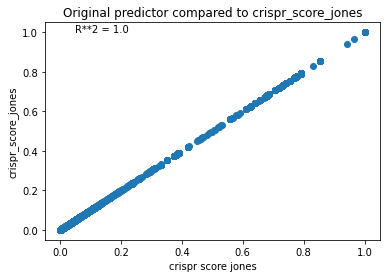

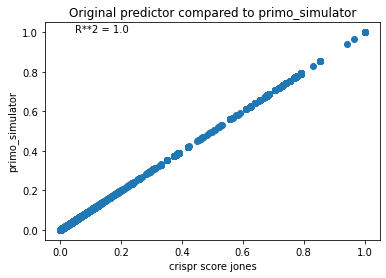

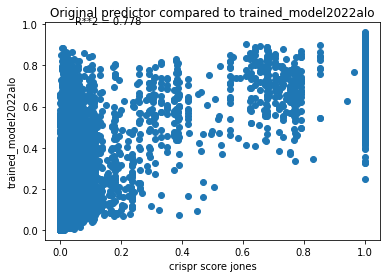

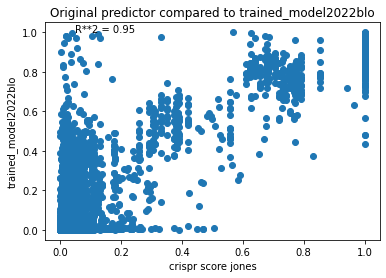

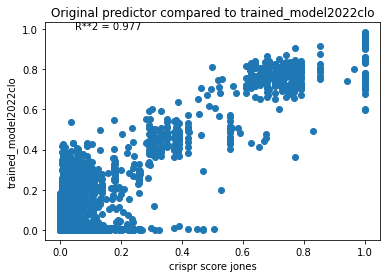

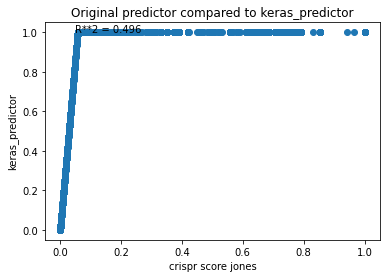

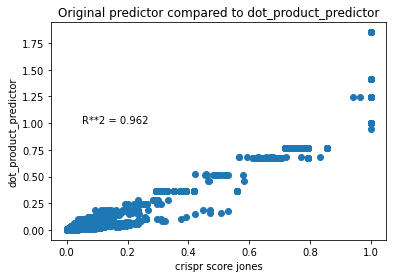

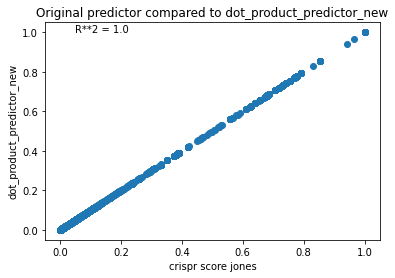

In [28]:
predictor_models_list = list(seq_pairs)[3:]
print(predictor_models_list)
for model in predictor_models_list:
    make_scatter(seq_pairs, model)


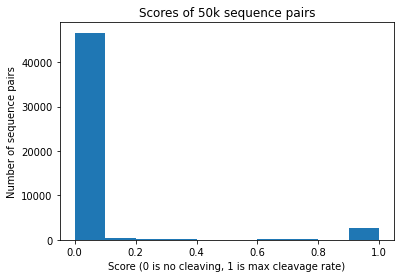

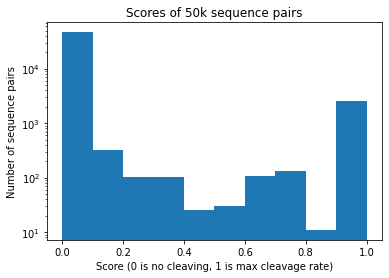

In [32]:
plt.hist(seq_pairs['crispr_score_jones'])
plt.title('Scores of 50k sequence pairs')
plt.ylabel('Number of sequence pairs')
plt.xlabel('Score (0 is no cleaving, 1 is max cleavage rate)')
plt.show()

plt.hist(seq_pairs['crispr_score_jones'])
plt.yscale('log')
plt.title('Scores of 50k sequence pairs')
plt.ylabel('Number of sequence pairs')
plt.xlabel('Score (0 is no cleaving, 1 is max cleavage rate)')
plt.show()

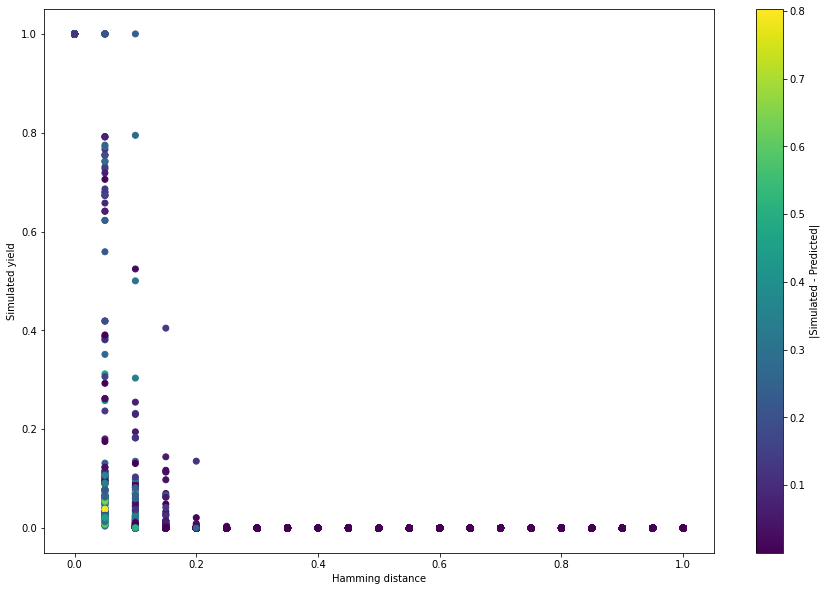

In [66]:
plt.figure(figsize=(15, 10))
plt.scatter(mut_rates, sim_results, c = np.abs(pred_yield.flatten() - sim_results))
plt.xlabel("Hamming distance")
plt.ylabel("Simulated yield")
plt.colorbar(label="|Simulated - Predicted|")

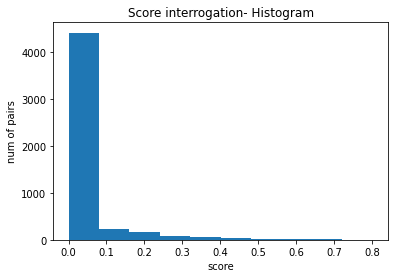

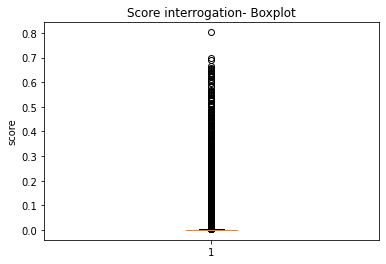

In [67]:
errors = np.abs(pred_yield.flatten() - sim_results)

plt.hist(errors)
plt.xlabel('score')
plt.ylabel('num of pairs')
plt.title('Score interrogation- Histogram')
plt.show()

plt.boxplot(errors)
plt.ylabel('score')
plt.title('Score interrogation- Boxplot')
plt.show()